### Import Packages

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from typing import TypedDict, Annotated, List
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain.memory import ChatMessageHistory
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain.vectorstores import FAISS
from dotenv import load_dotenv
import os

### Load API Keys and Enable Langsmith tracking

In [ ]:
load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
hf_api_key = os.getenv("HUGGINGFACE_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Chatbot_with_RAG_and_Langraph"

### Initialize Gemini LLM model

In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",  # or gemini-pro if you want
    google_api_key=google_api_key,
    temperature=0.3,
    top_k=4
)
llm

### Load embedding model and setup retriver

In [ ]:
embedding_model = HuggingFaceInferenceAPIEmbeddings(
    api_key=hf_api_key,
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = FAISS.load_local("../vectorstores/dxfactor", embedding_model, allow_dangerous_deserialization=True)

retriever = vectorstore.as_retriever()
retriever

### Build Chatbot with Langraph

In [ ]:
import pprint

In [ ]:
class ChatState(TypedDict, total=False):  # <-- `total=False` makes all fields optional
    chat_history: Annotated[List[BaseMessage], "chat_history"]
    retrieved_context: Annotated[str, "retrieved_context"]
    
def retrieve(state: ChatState) -> ChatState:
    pprint.pprint(state)

    messages = state.get("chat_history", [])

    user_msg = messages.content[-1]
    docs = retriever.invoke(user_msg)
    context = "\n\n".join(doc.page_content for doc in docs)

    return {"chat_history": messages, "retrieved_context": context}

In [ ]:
retrieve({"chat_history": HumanMessage(content=["What is the revenue in Q2?"])})

In [ ]:
def start_node(state: ChatState) -> ChatState:
    pprint.pprint(state)
    state["chat_history"] = HumanMessage(content=["What is the revenue in Q2?"])
    return state

In [ ]:
# ---------------------
# Define state shape
# ---------------------
class ChatState(TypedDict):  # <- total=False to make optional fields ok
    input: HumanMessage
    chat_history: Annotated[List[BaseMessage], 'chat_history']
    output: AIMessage
    retrieved_context: str

def start_node(state: ChatState) -> ChatState:
    pprint.pprint(state)
    return state

# --------------------------
# Define retriever node
# --------------------------
def retrieve(state: ChatState) -> ChatState:
    pprint.pprint(state)

    messages = state.get("chat_history", [])
    user_messages = [msg for msg in messages if isinstance(msg, HumanMessage)]
    user_msg = user_messages.content[-1] if user_messages else ""

    docs = retriever.invoke(user_msg)
    context = "\n\n".join(doc.page_content for doc in docs)

    return {
        "chat_history": messages,
        "retrieved_context": context
    }

# -------------------------
# Define generate node
# -------------------------
def generate(state: ChatState) -> ChatState:
    messages = state.get("chat_history", [])
    context = state.get("retrieved_context", "")

    # Safely get latest human message
    user_messages = [msg for msg in messages if isinstance(msg, HumanMessage)]
    user_question = user_messages[-1].content if user_messages else ""

    prompt = f"""Answer the user's question using ONLY the following context. 
If the answer is not in the context, say you don't know.

Context:
{context}

Question: {user_question}
"""

    response = llm.invoke(prompt)
    ai_msg = AIMessage(content=response.content)

    print(response.content)

    return {
        "chat_history": messages + [ai_msg],
        "retrieved_context": context,
        "output": ai_msg
    }

# ---------------------------
# Build the LangGraph
# ---------------------------
builder = StateGraph(ChatState)
builder.add_node("start", start_node)
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

builder.set_entry_point("start")
builder.add_edge("start", "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

graph = builder.compile()

# ------------------------------------------
# Add memory with RunnableWithMessageHistory
# ------------------------------------------
# Memory store to keep track of chat sessions
memory_store = {}

def get_memory(session_id: str) -> BaseChatMessageHistory:
    if session_id not in memory_store:
        memory_store[session_id] = ChatMessageHistory()
    return memory_store[session_id]

# Creating the graph with memory handling
graph_with_history = RunnableWithMessageHistory(
    graph,
    get_session_history=get_memory,
    input_messages_key="input",  # You'll pass the user message here
    history_messages_key="chat_history"  # This is used by the state
)

In [118]:
from langchain_core.messages import HumanMessage

response = graph_with_history.invoke(
    input={"input": HumanMessage(content=["Why use dxfactor?"])},
    config={"configurable": {"session_id": "user-123"}}
)

print(response)

{'chat_history': [],
 'input': HumanMessage(content=['Why use dxfactor?'], additional_kwargs={}, response_metadata={})}
{'chat_history': [],
 'input': HumanMessage(content=['Why use dxfactor?'], additional_kwargs={}, response_metadata={})}
I don't know.
{'input': HumanMessage(content=['Why use dxfactor?'], additional_kwargs={}, response_metadata={}), 'chat_history': [AIMessage(content="I don't know.", additional_kwargs={}, response_metadata={})], 'output': AIMessage(content="I don't know.", additional_kwargs={}, response_metadata={}), 'retrieved_context': '3.4 Enforcement.We reserve the right (but have no obligation) to review, refuse and/or remove any User Content in our sole discretion, and to investigate and/or take appropriate action against you in our sole discretion if you violate the Acceptable Use Policy or any other provision of these Terms or otherwise create liability for us or any other person. Such action may include removing or modifying your User Content, terminating you

In [91]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import Runnable
from langchain_core.messages import HumanMessage, AIMessage

# Define state schema (chat_history is managed by RunnableWithMessageHistory)
from typing import TypedDict, List, Union

class ChatState(TypedDict):
    input: HumanMessage
    chat_history: List[Union[HumanMessage, AIMessage]]
    output: AIMessage

# Chat function using your llm (already initialized)
def chat_node(state: ChatState) -> ChatState:
    user_msg = state["input"]
    chat_history = state["chat_history"]
    # Get the response from the LLM
    response = llm.invoke(chat_history + [user_msg])
    return {
        "input": user_msg,
        "chat_history": chat_history + [user_msg, response],
        "output": response  # this is key!
    }

# Build the graph
builder = StateGraph(ChatState)
builder.add_node("chat", chat_node)
builder.set_entry_point("chat")
builder.add_edge("chat", END)

graph = builder.compile()

memory_store = {}

def get_memory(session_id: str) -> BaseChatMessageHistory:
    if session_id not in memory_store:
        memory_store[session_id] = ChatMessageHistory()
    pprint.pprint(memory_store)
    return memory_store[session_id]

# Creating the graph with memory handling
graph_with_history = RunnableWithMessageHistory(
    graph,
    get_session_history=get_memory,
    input_messages_key="input",  # You'll pass the user message here
    history_messages_key="chat_history"  # This is used by the state
)


In [92]:

from langchain_core.messages import HumanMessage

response = graph_with_history.invoke(
    input={"input": HumanMessage(content=["What is the revenue in Q2?"])},
    config={"configurable": {"session_id": "user-123"}}
)

print(response)

{'user-123': InMemoryChatMessageHistory(messages=[])}
{'input': HumanMessage(content=['What is the revenue in Q2?'], additional_kwargs={}, response_metadata={}), 'chat_history': [HumanMessage(content=['What is the revenue in Q2?'], additional_kwargs={}, response_metadata={}), AIMessage(content="I am unable to access real-time information, including financial data like quarterly revenue. To find the revenue for Q2, you would need to consult a reliable source such as:\n\n*   **The company's official investor relations website:** Look for press releases, quarterly reports, or financial statements.\n*   **Financial news websites:** Reputable sources like Reuters, Bloomberg, or the Wall Street Journal often report on company earnings.\n*   **Financial data providers:** Services like FactSet or Refinitiv provide detailed financial data.\n\nWhen searching, be sure to specify the company you are interested in and the year for which you want the Q2 revenue.", additional_kwargs={}, response_meta

In [94]:
response = graph_with_history.invoke(
    input={"input": HumanMessage(content=["Ok, that's not a problem."])},
    config={"configurable": {"session_id": "user-123"}}
)

print(response)

{'user-123': InMemoryChatMessageHistory(messages=[HumanMessage(content=['What is the revenue in Q2?'], additional_kwargs={}, response_metadata={}), AIMessage(content="I am unable to access real-time information, including financial data like quarterly revenue. To find the revenue for Q2, you would need to consult a reliable source such as:\n\n*   **The company's official investor relations website:** Look for press releases, quarterly reports, or financial statements.\n*   **Financial news websites:** Reputable sources like Reuters, Bloomberg, or the Wall Street Journal often report on company earnings.\n*   **Financial data providers:** Services like FactSet or Refinitiv provide detailed financial data.\n\nWhen searching, be sure to specify the company you are interested in and the year for which you want the Q2 revenue.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite

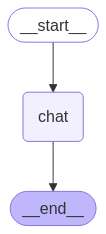

In [93]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Running Chatbot

In [ ]:
session_id = "user1"

# Initial empty message list to start the chat
chat_history = []

print("📢 LangGraph Chatbot initialized. Type your question.")
print("💡 Type 'quit', 'exit', or 'q' to end the conversation.\n")

while True:
    user_input = input("You: ")

    if user_input.lower() in {"quit", "exit", "q"}:
        print("👋 Chat ended.")
        break

    # Wrap user input as a HumanMessage
    chat_history.append(HumanMessage(content=user_input))

    # Invoke the chatbot with chat history
    result = graph_with_history.invoke(
        {"messages": chat_history, "context": ""},  
        config={"configurable": {"session_id": session_id}}
    )

    # Get the last message from result and print it
    response = result["messages"][-1].content
    print("Bot:", response)

    # Append bot response to history
    chat_history.append(AIMessage(content=response))

In [121]:
# Define state shape
class ChatState(TypedDict, total=False):
    chat_history: Annotated[List[BaseMessage], "chat_history"]
    retrieved_context: Annotated[str, "retrieved_context"]
    output: Annotated[str, "output"]  # Ensure output is included in the state


# Define start node
def start_node(state: ChatState) -> ChatState:
    state["chat_history"] = [HumanMessage(content=["Hi!"])]
    state["output"] = "Welcome to the chat!"  # Provide initial output
    return state


# Define retrieve node
def retrieve(state: ChatState) -> ChatState:
    print(state)
    messages = state.get("chat_history", [])

    if not messages:
        raise Exception("No chat history found.")

    user_msg = messages[-1].content[0]  # Get last user's message
    docs = retriever.invoke(user_msg)
    context = "\n\n".join(doc.page_content for doc in docs) if docs else ""

    state["retrieved_context"] = context
    state["output"] = context if context else "No relevant context found."  # Update output based on retrieved context
    return state


# Define generate node
def generate(state: ChatState) -> ChatState:
    messages = state.get("chat_history", [])
    context = state.get("retrieved_context", "")

    if not messages:
        raise Exception("No chat history found.")

    user_question = messages[-1].content[0]  # Get the content of the last HumanMessage

    # Improved prompt with clearer instructions
    prompt = f"""Based on the context provided, answer the user's question as accurately as possible.   
If you cannot find an answer based on the context, try suggesting that the user provide more details or rephrase their question.  

Context:  
{context}  

Question: {user_question}  
"""

    response = llm.invoke(prompt)
    new_message = AIMessage(content=[response.content])

    # Append the new AIMessage to the chat history
    messages.append(new_message)

    # Handling case for "I don't know."
    output_message = response.content
    if output_message.lower() == "i don't know.":
        # Suggestion for the user or ask for more information
        output_message = "Unfortunately, I couldn't find an answer. Could you provide more details or ask a different question?"

        # Return the updated state with output
    state["chat_history"] = messages
    state["output"] = output_message  # Store the AI's response as output

    return state

# Build the LangGraph
builder = StateGraph(ChatState)
builder.add_node("start", start_node)
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

builder.set_entry_point("start")
builder.add_edge("start", "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

graph = builder.compile()

# Add memory with RunnableWithMessageHistory
# Memory store to keep track of chat sessions
memory_store = {}


def get_memory(session_id: str) -> ChatMessageHistory:
    if session_id not in memory_store:
        memory_store[session_id] = ChatMessageHistory()
    return memory_store[session_id]


# Creating the graph with memory handling
graph_with_history = RunnableWithMessageHistory(
    graph,
    get_session_history=get_memory,
    input_messages_key="input",  # You'll pass the user message here
    history_messages_key="chat_history"  # This is used by the state
)

In [128]:
### Invoke function
response = graph_with_history.invoke(
    input={"input": HumanMessage(content=["What is data engineering"])},
    config={"configurable": {"session_id": "user-123"}}
)

# Print the response
print(response)

{'chat_history': [HumanMessage(content=['Hi!'], additional_kwargs={}, response_metadata={})], 'output': 'Welcome to the chat!'}
{'chat_history': [HumanMessage(content=['Hi!'], additional_kwargs={}, response_metadata={}), AIMessage(content=['Hi! Based on the provided context, I can tell you that DXFactor has the following open positions:\n\n*   DXFactor - 9 open roles\n*   Data Science - 1 open role\n*   Talent Acquisition / Recruitment - 1 open role\n\nYou can contact them at inquiry@dxfactor.com.'], additional_kwargs={}, response_metadata={})], 'retrieved_context': 'Open Positions\nDXFactor- 9 \n                  Open roles\nData Science- 1 \n                  Open role\nTalent Acquisition / Recruitment- 1 \n                  Open role\ninquiry@dxfactor.com\nCompany\nSolutions\nResources\nCertification\nmagic_popup_12\n\n========== Fitgenai ==========\nURL: https://dxfactor.com/fitgenai/\n\n========== Contact Us ==========\nURL: https://dxfactor.com/contact-us/\n\nInnovation\nCreativi